In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
from scipy.interpolate import interp1d
# from plot_funcs import *
from matplotlib import patches

In [2]:
def modecount_rebin(kk, pk, modes, minmodes=20, ndesired=200): #from MP-Gadget
    """Rebins a power spectrum so that there are sufficient modes in each bin"""
    assert np.all(kk) > 0
    logkk=np.log10(kk)
    mdlogk = (np.max(logkk) - np.min(logkk))/ndesired
    istart=iend=1
    count=0
    k_list=[kk[0]]
    pk_list=[pk[0]]
    targetlogk=mdlogk+logkk[istart]
    while iend < np.size(logkk)-1:
        count+=modes[iend]
        iend+=1
        if count >= minmodes and logkk[iend-1] >= targetlogk:
            pk1 = np.sum(modes[istart:iend]*pk[istart:iend])/count
            kk1 = np.sum(modes[istart:iend]*kk[istart:iend])/count
            k_list.append(kk1)
            pk_list.append(pk1)
            istart=iend
            targetlogk=mdlogk+logkk[istart]
            count=0
    k_list = np.array(k_list)
    pk_list = np.array(pk_list)
    return (k_list, pk_list)

def load_rebin(spec_file):
    k_raw, Pk_raw, modes = np.loadtxt(spec_file, usecols=(0,1,2), unpack=True)
    k, Pk = modecount_rebin(k_raw, Pk_raw, modes)
    return k, Pk

In [3]:
# relative difference
def rel_dif(x1, y1, x2, y2):
    # Transform x1, x2, y1, and y2 into log10 space
    log10_x1 = np.log10(x1)
    log10_x2 = np.log10(x2)
    log10_y1 = np.log10(y1)
    log10_y2 = np.log10(y2)

    # Define the common log10(x) range for interpolation
    common_log10_x_min = max(min(log10_x1), min(log10_x2))
    common_log10_x_max = min(max(log10_x1), max(log10_x2))
    common_log10_x = np.linspace(common_log10_x_min, common_log10_x_max, 100)

    # Interpolate log10_y1 and log10_y2 to the common log10_x grid
    interp_log10_y1 = interp1d(log10_x1, log10_y1, kind='linear')(common_log10_x)
    interp_log10_y2 = interp1d(log10_x2, log10_y2, kind='linear')(common_log10_x)

    # Transform interpolated log10 values back to the original space
    interp_y1 = 10**interp_log10_y1
    interp_y2 = 10**interp_log10_y2
    common_x = 10**common_log10_x  # Transform common_log10_x back to original x values

    # Compute (y2 - y1) / y1 in original space
    delta_y = (interp_y2 - interp_y1) / interp_y1
    return common_x, delta_y

In [4]:
def rMAE_av_cosmo(pred_parent, sim_parent, z, n_HF):
    Ps_pred, nz_ind = load_pred(pred_parent, z, n_HF)
    k_sim, Ps_sim = load_sim(sim_parent, z, nz_ind)
    # k, rAEs = rel_MAEs(k_sim, Ps_sim, k_sim, Ps_pred)
    k, rAEs = rel_MAEs_raw(k_sim, Ps_sim, k_sim, Ps_pred)
    rMAE_av = np.mean(rAEs, axis=0)

    rAE_av_k = np.mean(rAEs, axis=1)
    # rAE_av_k = rAEs.mean()   # average over all k and cosmologies
    print('z=', z, rAE_av_k)
    # print('z=', z, rAEs)
    # min and max
    rMAE_min, rMAE_max = np.min(rAEs, axis=0), np.max(rAEs, axis=0)
    return k, rMAE_av, rMAE_min, rMAE_max, rAEs

def load_pred(pred_parent, z, n_HF):
    Ps_pred = []
    nz_ind = []  # for matching sim spectra
    for i in range(n_HF):
        file_path = os.path.join(pred_parent, "matter_pow_mode_z%s.txt" % (z))
        if os.path.exists(file_path):
            # print(f"The file {file_path} exists.")
            data = np.loadtxt(file_path,)
            P_pred = data[i]
            Ps_pred.append(P_pred)
            nz_ind.append(i)
        else:
            print(f"The file {file_path} does not exist.")
            continue
    Ps_pred = np.array(Ps_pred)
    return Ps_pred, nz_ind

def load_sim(sim_parent, z, nz_ind):
    file_path = os.path.join(sim_parent, 'matter_power_297_Box100_Part75_27_Box100_Part300_z%s/test_output.txt' % z)
    k_path = os.path.join(sim_parent, 'matter_power_297_Box100_Part75_27_Box100_Part300_z%s/kf.txt' % z)
    lg_Ps = np.loadtxt(file_path)
    lg_Ps = lg_Ps[nz_ind]
    Ps_sim = 10**lg_Ps
    lg_k = np.loadtxt(k_path, usecols=(0))
    k_sim = 10**lg_k
    return k_sim, Ps_sim


def rel_MAEs(x1, y1, x2, y2):
    # Transform x1, x2, y1, and y2 into log10 space
    log10_x1 = np.log10(x1)
    log10_x2 = np.log10(x2)
    log10_y1 = np.log10(y1)
    log10_y2 = np.log10(y2)

    # Define the common log10(x) range for interpolation
    common_log10_x_min = max(min(log10_x1), min(log10_x2))
    common_log10_x_max = min(max(log10_x1), max(log10_x2))
    common_log10_x = np.linspace(common_log10_x_min, common_log10_x_max, 64)

    # Interpolate log10_y1 and log10_y2 to the common log10_x grid
    interp_log10_y1 = interp1d(log10_x1, log10_y1, kind='linear')(common_log10_x)
    interp_log10_y2 = interp1d(log10_x2, log10_y2, kind='linear')(common_log10_x)

    # Transform interpolated log10 values back to the original space
    interp_y1 = 10**interp_log10_y1
    interp_y2 = 10**interp_log10_y2
    common_x = 10**common_log10_x  # Transform common_log10_x back to original x values

    # Compute (y2 - y1) / y1 in original space
    rMAE_y = np.abs((interp_y2 / interp_y1) - 1)
    return common_x, rMAE_y

def rel_MAEs_raw(x1, y1, x2, y2):

    # Compute (y2 - y1) / y1 in original space
    rMAE_y = np.absolute((y2 / y1) - 1)
    return x1, rMAE_y

In [5]:
# P_pred = np.loadtxt('matter_pow_z0_l0.txt', usecols=(2))

z= 0 [0.02277661 0.01843577 0.0198224  0.0322417  0.02636291 0.019684
 0.02292711 0.02975343 0.03419887 0.08068273 0.04428999 0.02204091]
z= 0.2 [0.03467012 0.04792694 0.02496724 0.02787453 0.03326683 0.02822855
 0.02313579 0.04257958 0.05615524 0.01493403 0.02206259 0.02935545]
z= 0.5 [0.02571885 0.01591263 0.01237411 0.01834197 0.00866274 0.01305272
 0.01807941 0.00871811 0.05207303 0.02557368 0.01612418 0.01434833]
z= 1 [0.013449   0.01103338 0.01025587 0.00676905 0.00966338 0.00925502
 0.00879366 0.01462822 0.02954115 0.01061033 0.01497889 0.00905624]
z= 2 [0.00335582 0.01224871 0.00919759 0.00767763 0.01201838 0.01114089
 0.00913232 0.0075567  0.01590819 0.00701925 0.013709   0.00698688]
z= 3 [0.00382179 0.00538555 0.00505858 0.00256947 0.00281409 0.01082869
 0.00571887 0.00211221 0.0095743  0.01030208 0.0027076  0.00555019]
average over k and z: 0.018302528636187334


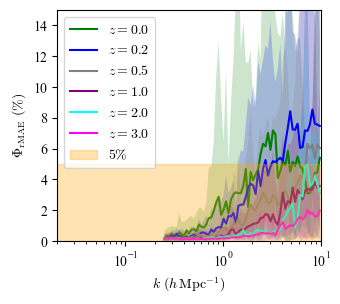

In [10]:
# relative
# sim_parent = "/work2/01317/yyang440/frontera/cosmo_11p_sims/data_for_emu" # frontera
sim_parent = "../../data/narrow" 
pred_parent = './'

n_test = 12

fig, ax = plt.subplots(figsize=(3.4,3.))
plt.rcParams['font.family'] = 'Times New Roman'

# Set math font style
plt.rcParams['mathtext.fontset'] = 'cm'

zs = np.array([0,0.2, 0.5, 1, 2, 3, 4, 9, 49, 99])
zs_str = ['0', '0.2', '0.5', '1', '2', '3', '4', '9', '49', '99']
a = 1/(1+zs)

color_list = ['green', 'blue', 'grey', 'purple', 'cyan', 'magenta']

# ax.plot([], [], color='black', label='HF')
# # ax.plot([], [], color='black', linestyle=':', label='L1')
# ax.plot([], [], color='black', linestyle='--', label='Linear')
rMAE_zs = []

for i, scale in enumerate(a):
    if i==6:
        break
    c = color_list[i]
    # k_L1, Pk_L1 = load_rebin(os.path.join(sim_L1, "output/powerspectrum-%.4f.txt" % scale))
    # k_L2, Pk_L2 = load_rebin(os.path.join(sim_L2, "output/powerspectrum-%.4f.txt" % scale))
    k, rMAE, rMAE_min, rMAE_max, rAEs = rMAE_av_cosmo(pred_parent, sim_parent, zs_str[i], n_test)
    rMAE_zs.append(rMAE.mean())
    # k_HF, Pk_HF = load_rebin(os.path.join(sim_HF, "output/powerspectrum-%.4f.txt" % scale))
    # k_li, Pk_li = np.loadtxt(os.path.join(sim_HF, "camb_linear/ics_matterpow_%s.dat" % zs_str[i]), usecols=(0,1), unpack=True)

    ax.plot(k, rMAE/1e-2, color=c, label=r"$z=%.1f$" % zs[i])
    # ax.plot(k_li, Pk_li, '--', color=c)
    # individual
    # for rAE in rAEs:
    #     ax.plot(k, rAE/1e-2, color=c, alpha=0.4)

    ax.fill_between(k, rMAE_min/1e-2, rMAE_max/1e-2, facecolor=c, alpha=0.2, edgecolor='none')
    
rMAE_zs = np.array(rMAE_zs)
rMAE_zs_mean = rMAE_zs.mean()
print('average over k and z:', rMAE_zs_mean)
    # plt.loglog(k_HF, Pk_HF, color=c, label=r"$z=%.1f$" % zs[i])
    

    # if labels is not None:

# ax.set_ylim(.07,.5e5)
# ax.legend(loc='best')
# ax.set_yscale('log')
ax.set_ylabel(r'$\Phi_{\mathrm{rMAE}}\ (\%)$')
# plt.xlabel(r'$k\ (h\,\mathrm{Mpc}^{-1})$')
# plt.ylabel(r'$P(k)\ (h^{-3}\mathrm{Mpc}^3)$')
# ax.plot([], [], color='black', label='HF')
# ax.plot([], [], color='black', label='HF w.r.t. Linear')
# ax.plot([], [], color='black', linestyle='--', label='L2 w.r.t. HF')
ax.set_ylim(0., 15)
ax.set_xscale('log')
ax.set_xlabel(r'$k\ (h\,\mathrm{Mpc}^{-1})$')
# ax.set_ylabel(r'$(P_\mathrm{HF}-P_\mathrm{Li})/P_\mathrm{Li}$')

xlim1 = .02
xlim2 = 10
ax.set_xlim(xlim1, xlim2)

square = patches.Rectangle((xlim1, -0.0), xlim2-xlim1, 5, color='orange', alpha=.3, zorder=2, label=r'$5\%$')  # alpha ranges from 0 (transparent) to 1 (opaque)
# square1 = patches.Rectangle((xlim1, -0.01), xlim2-xlim1, 0.02, color='blue', alpha=.3, zorder=2, label=r'$1\%$')  # alpha ranges from 0 (transparent) to 1 (opaque)

# Add the square to the axes
ax.add_patch(square)
# ax.add_patch(square1)
ax.legend(loc='upper left')
# ax.set_yticks([-0.2,-.1,0,.1,.2])

# plt.xlim([0.005, 100])
# plt.ylim([.01,4e5])
# plt.ylim([-.3, .3])
plt.show()
# plt.savefig('matter_pow_nonl_linear_ratio.pdf', bbox_inches='tight')

In [7]:
a =  [60, 61, 62, 168, 169, 170, 282, 283, 284, 6, 7, 8, 192, 193, 194, 189, 190, 191, 90, 91, 92, 207, 208, 209, 24, 25, 26, 201, 202, 203, 156, 157, 158, 45, 46, 47, 48, 49, 50, 285, 286, 287, 105, 106, 107, 9, 10, 11, 222, 223, 224, 225, 226, 227, 270, 271, 272, 126, 127, 128, 81, 82, 83, 18, 19, 20, 276, 277, 278, 33, 34, 35, 60, 61, 62, 234, 235, 236, 261, 262, 263, 153, 154, 155, 150, 151, 152, 195, 196, 197, 54, 55, 56, 69, 70, 71, 21, 22, 23, 63, 64, 65, 183, 184, 185, 111, 112, 113, 192, 193, 194, 135, 136, 137, 180, 181, 182, 249, 250, 251, 198, 199, 200, 87, 88, 89, 12, 13, 14, 117, 118, 119, 171, 172, 173, 96, 97, 98, 102, 103, 104, 282, 283, 284, 246, 247, 248, 294, 295, 296, 228, 229, 230, 0, 1, 2, 123, 124, 125, 213, 214, 215, 120, 121, 122, 189, 190, 191, 237, 238, 239, 75, 76, 77, 291, 292, 293, 108, 109, 110, 231, 232, 233, 93, 94, 95, 36, 37, 38, 243, 244, 245, 15, 16, 17, 99, 100, 101, 138, 139, 140, 216, 217, 218, 3, 4, 5, 39, 40, 41, 51, 52, 53, 162, 163, 164, 30, 31, 32, 240, 241, 242, 273, 274, 275, 264, 265, 266, 78, 79, 80, 288, 289, 290, 66, 67, 68, 165, 166, 167, 174, 175, 176, 141, 142, 143, 129, 130, 131, 204, 205, 206, 42, 43, 44, 147, 148, 149, 27, 28, 29, 258, 259, 260, 279, 280, 281, 144, 145, 146, 72, 73, 74, 255, 256, 257, 168, 169, 170, 267, 268, 269, 6, 7, 8, 159, 160, 161, 210, 211, 212, 84, 85, 86]
b = [6, 7, 8, 15, 16, 17, 24, 25, 26, 0, 1, 2, 21, 22, 23, 18, 19, 20]

In [8]:
len(a)

294

In [9]:
len(b)

18